#  Sequential Models in NLP - Sarcasm Detection 

## George Mathew 

### Package Version:
- tensorflow==2.2.0
- pandas==1.0.5
- numpy==1.18.5
- google==2.0.3

# Sarcasm Detection

### Dataset

#### Acknowledgement
Misra, Rishabh, and Prahal Arora. "Sarcasm Detection using Hybrid Neural Network." arXiv preprint arXiv:1908.07414 (2019).

**Required Files given in below link.**

https://drive.google.com/drive/folders/1xUnF35naPGU63xwRDVGc-DkZ3M8V5mMk

In [1]:
import pandas as pd
import numpy as np
import re, nltk
import tensorflow as tf
from nltk.corpus import stopwords
from sklearn import metrics

from tensorflow.keras.preprocessing.sequence import pad_sequences

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense, LSTM, Bidirectional, Dropout, TimeDistributed
from keras import optimizers
from keras.initializers import Constant
from keras.optimizers import Adam

import matplotlib.pyplot as plt

In [2]:
 from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
os.chdir('/content/drive/My Drive/AIML/Module 10/Project 11/Data')

### Load Data (5 Marks)

In [4]:
headlines_df = pd.read_json("Sarcasm_Headlines_Dataset.json", lines=True)
headlines_df.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


In [5]:
headlines_df.count()

article_link    26709
headline        26709
is_sarcastic    26709
dtype: int64

In [6]:
nltk.download('stopwords')

stopwords = set(stopwords.words('english'))

def preprocess_text(df, column_name=''):

  # Select only alphabets
  df[column_name] = df[column_name].apply(lambda x: re.sub('[^A-Za-z]+', ' ', x))

  # Convert text to lowercase
  df[column_name] = df[column_name].apply(lambda x: x.lower())

  # Strip unwanted spaces
  df[column_name] = df[column_name].apply(lambda x: x.strip())

  # Remove stopwords
  df[column_name] = df[column_name].apply(lambda x: ' '.join([word for word in x.split() if word not in stopwords]))

  # Replace empty strings with Null
  df[column_name].replace('', np.nan, inplace = True)

  # Drop Null values
  df = df.dropna()

  return df

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [7]:
headlines_df = preprocess_text(headlines_df, column_name='headline')

In [8]:
headlines_df.count()

article_link    26707
headline        26707
is_sarcastic    26707
dtype: int64

In [9]:
headlines_df.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues secret black c...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,roseanne revival catches thorny political mood...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting fear son web series closest thing...,1
3,https://politics.theonion.com/boehner-just-wan...,boehner wants wife listen come alternative deb...,1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j k rowling wishes snape happy birthday magica...,0


### Drop `article_link` from dataset (5 Marks)

In [10]:
headlines_df = headlines_df[['headline', 'is_sarcastic']]

In [11]:
headlines_df.head()

,headline,is_sarcastic
0,former versace store clerk sues secret black c...,0
1,roseanne revival catches thorny political mood...,0
2,mom starting fear son web series closest thing...,1
3,boehner wants wife listen come alternative deb...,1
4,j k rowling wishes snape happy birthday magica...,0


In [12]:
for i in range(5):
  print(headlines_df['headline'][i])
  print("\n")

former versace store clerk sues secret black code minority shoppers


roseanne revival catches thorny political mood better worse


mom starting fear son web series closest thing grandchild


boehner wants wife listen come alternative debt reduction ideas


j k rowling wishes snape happy birthday magical way




### Get length of each headline and add a column for that (5 Marks)

In [13]:
headlines_df['len_headline'] = headlines_df['headline'].apply(lambda x: len(x.split(" ")))
headlines_df.head()

,headline,is_sarcastic,len_headline
0,former versace store clerk sues secret black c...,0,10
1,roseanne revival catches thorny political mood...,0,8
2,mom starting fear son web series closest thing...,1,9
3,boehner wants wife listen come alternative deb...,1,9
4,j k rowling wishes snape happy birthday magica...,0,9


In [14]:
headlines_df.is_sarcastic.value_counts()

0    14983
1    11724
Name: is_sarcastic, dtype: int64

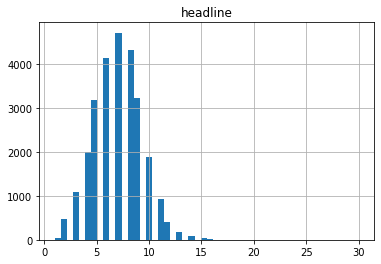

In [15]:
import matplotlib.pyplot as plt
text_word_count = []
headline_word_count = []

# populate the lists with headline length

for i in headlines_df['headline']:
  headline_word_count.append(len(i.split()))

length_df = pd.DataFrame({'headline':headline_word_count})
length_df.hist(bins = 50)
plt.show()

In [16]:
cnt=0
for i in headlines_df['headline']:
    if(len(i.split())<=25):
        cnt=cnt+1
print(cnt/len(headlines_df['headline']))

0.9999625566330924


### Initialize parameter values
- Set values for max_features, maxlen, & embedding_size
- max_features: Number of words to take from tokenizer(most frequent words)
- maxlen: Maximum length of each sentence to be limited to 25
- embedding_size: size of embedding vector

In [17]:
max_features = 10000
maxlen = 25
embedding_size = 200

### Apply `tensorflow.keras` Tokenizer and get indices for words (5 Marks)
- Initialize Tokenizer object with number of words as 10000
- Fit the tokenizer object on headline column
- Convert the text to sequence


In [18]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(headlines_df['headline'], headlines_df['is_sarcastic'],test_size=0.2)

In [19]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((21365,), (21365,), (5342,), (5342,))

In [20]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,test_size=0.2)

In [21]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((17092,), (17092,), (4273,), (4273,))

In [22]:
feature_tokenizer = Tokenizer(num_words = max_features, oov_token = True)
feature_tokenizer.fit_on_texts(X_train)

X_train_seq = feature_tokenizer.texts_to_sequences(X_train)
X_test_seq = feature_tokenizer.texts_to_sequences(X_test)
X_val_seq = feature_tokenizer.texts_to_sequences(X_val)

In [23]:
print("Number of Samples in X_train:", len(X_train))       
print(X_train[:1])
print(X_train_seq[:1])
print(y_train[:1])

Number of Samples in X_train: 17092
24181    restore power restorative sleep
Name: headline, dtype: object
[[2858, 235, 1, 470]]
24181    0
Name: is_sarcastic, dtype: int64


In [24]:
print("Number of Samples in X_test:", len(X_test))       
print(X_test[:1])
print(X_test_seq[:1])
print(y_test[:1])

Number of Samples in X_test: 5342
4802    remembering pat conroy words quotes
Name: headline, dtype: object
[[3194, 5185, 1, 460, 3148]]
4802    0
Name: is_sarcastic, dtype: int64


In [25]:
print("Number of Samples in X_val:", len(X_val))       
print(X_val[:1])
print(X_val_seq[:1])
print(y_val[:1])

Number of Samples in X_val: 4273
4294    several probably killed shooting lazy police r...
Name: headline, dtype: object
[[2593, 356, 232, 197, 3812, 52, 7, 1289]]
4294    1
Name: is_sarcastic, dtype: int64


In [26]:
print('Found %d unique words.' % len(feature_tokenizer.word_index))

Found 20138 unique words.


### Pad sequences (5 Marks)
- Pad each example with a maximum length
- Convert target column into numpy array

In [27]:
X_train_pad = pad_sequences(X_train_seq, maxlen = maxlen, padding='post')
X_val_pad = pad_sequences(X_val_seq, maxlen = maxlen, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen = maxlen, padding='post')

In [28]:
X_train_pad.shape, X_test_pad.shape, X_val_pad.shape

((17092, 25), (5342, 25), (4273, 25))

In [29]:
y_train.shape, y_test.shape, y_val.shape

((17092,), (5342,), (4273,))

In [30]:
print(X_train_pad[1:2])
print(X_train[1:2])
print(y_train[1:2])

[[ 628    3    5 3598   13  805 4111    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0]]
21211    chinese new year boom time fake girlfriends
Name: headline, dtype: object
21211    0
Name: is_sarcastic, dtype: int64


### Vocab mapping
- There is no word for 0th index

In [31]:
feature_tokenizer.word_index

{True: 1,
 'trump': 2,
 'new': 3,
 'man': 4,
 'year': 5,
 'one': 6,
 'report': 7,
 'area': 8,
 'u': 9,
 'woman': 10,
 'donald': 11,
 'day': 12,
 'time': 13,
 'says': 14,
 'first': 15,
 'women': 16,
 'get': 17,
 'like': 18,
 'obama': 19,
 'old': 20,
 'people': 21,
 'world': 22,
 'life': 23,
 'house': 24,
 'nation': 25,
 'clinton': 26,
 'still': 27,
 'back': 28,
 'make': 29,
 'white': 30,
 'could': 31,
 'family': 32,
 'way': 33,
 'study': 34,
 'americans': 35,
 'black': 36,
 'gop': 37,
 'would': 38,
 'show': 39,
 'school': 40,
 'death': 41,
 'watch': 42,
 'president': 43,
 'years': 44,
 'know': 45,
 'american': 46,
 'last': 47,
 'home': 48,
 'best': 49,
 'good': 50,
 'bill': 51,
 'police': 52,
 'mom': 53,
 'going': 54,
 'america': 55,
 'really': 56,
 'hillary': 57,
 'things': 58,
 'say': 59,
 'state': 60,
 'party': 61,
 'finds': 62,
 'every': 63,
 'need': 64,
 'take': 65,
 'love': 66,
 'kids': 67,
 'may': 68,
 'parents': 69,
 'getting': 70,
 'health': 71,
 'big': 72,
 'video': 73,
 'cour

### Set number of words
- Since the above 0th index doesn't have a word, add 1 to the length of the vocabulary

In [32]:
num_words = len(feature_tokenizer.word_index) + 1
print(num_words)

20139


### Load Glove Word Embeddings (5 Marks)

### Create embedding matrix

In [33]:
EMBEDDING_FILE = 'glove.6B.200d.txt'

embeddings = {}
for o in open(EMBEDDING_FILE, encoding="utf8"):
    word = o.split(" ")[0]
    #print(word)
    embd = o.split(" ")[1:]
    embd = np.asarray(embd, dtype='float32')
    #print(embd)
    embeddings[word] = embd

# create a weight matrix for words in training docs
embedding_matrix = np.zeros((num_words, 200))

for word, i in feature_tokenizer.word_index.items():
	embedding_vector = embeddings.get(word)
	if embedding_vector is not None:
		embedding_matrix[i] = embedding_vector

In [34]:
print('Found %s word vectors.' % len(embeddings))

Found 400000 word vectors.


### Define model (10 Marks)
- Hint: Use Sequential model instance and then add Embedding layer, Bidirectional(LSTM) layer, flatten it, then dense and dropout layers as required. 
In the end add a final dense layer with sigmoid activation for binary classification.

In [35]:
EPOCHS = 20
BATCH_SIZE = 128
threshold = 0.99

In [36]:
def lstm():
    model = Sequential()
    
    model.add(Embedding(num_words,
                        embedding_size,
                        embeddings_initializer=Constant(embedding_matrix), 
                        input_length=maxlen,
                        trainable=True))
    
    model.add(Bidirectional(LSTM(32, return_sequences=True, recurrent_dropout=0.1, dropout=0.1)))
    model.add(Bidirectional(LSTM(64, recurrent_dropout=0.1, dropout=0.1)))
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Flatten())
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))   
    model.summary()
    return model

lsmod = lstm()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 25, 200)           4027800   
_________________________________________________________________
bidirectional (Bidirectional (None, 25, 64)            59648     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               66048     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               16512     
_________________________________________________________________
flatten (Flatten)            (None, 128)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0

### Compile the model (5 Marks)

In [37]:
opt = Adam(learning_rate=0.001)
lsmod.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [38]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') > threshold:
            self.model.stop_training = True
            print(' \n Terminating training as model reached ' + str(threshold * 100) + ' % accuracy \n')

callback_func = myCallback()

### Fit the model (5 Marks)

In [39]:
lshist = lsmod.fit(X_train_pad, y_train,
         epochs = EPOCHS,
         batch_size = BATCH_SIZE,
         callbacks = [callback_func],
         validation_data = (X_val_pad, y_val))

Epoch 1/20
134/134 [==============================] - 54s 405ms/step - loss: 0.5390 - accuracy: 0.7203 - val_loss: 0.4560 - val_accuracy: 0.7882
Epoch 2/20
134/134 [==============================] - 54s 403ms/step - loss: 0.3617 - accuracy: 0.8407 - val_loss: 0.4153 - val_accuracy: 0.8109
Epoch 3/20
134/134 [==============================] - 54s 403ms/step - loss: 0.2628 - accuracy: 0.8863 - val_loss: 0.4349 - val_accuracy: 0.8137
Epoch 4/20
134/134 [==============================] - 53s 399ms/step - loss: 0.1917 - accuracy: 0.9237 - val_loss: 0.4855 - val_accuracy: 0.8074
Epoch 5/20
134/134 [==============================] - 53s 397ms/step - loss: 0.1391 - accuracy: 0.9476 - val_loss: 0.5530 - val_accuracy: 0.8182
Epoch 6/20
134/134 [==============================] - 53s 398ms/step - loss: 0.1092 - accuracy: 0.9598 - val_loss: 0.6026 - val_accuracy: 0.8100
Epoch 7/20
134/134 [==============================] - 53s 398ms/step - loss: 0.0780 - accuracy: 0.9718 - val_loss: 0.7556 - val_ac

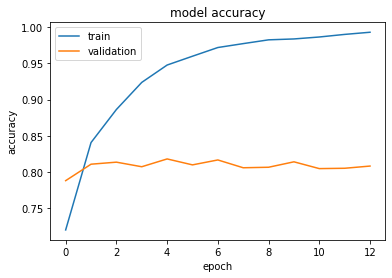

In [40]:
plt.plot(lshist.history['accuracy'])
plt.plot(lshist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

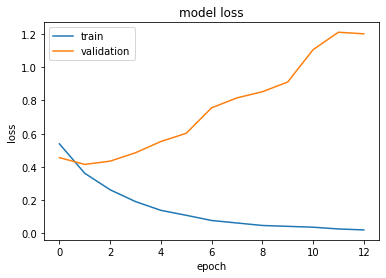

In [41]:
plt.plot(lshist.history['loss'])
plt.plot(lshist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

### Predict

In [42]:
scores = lsmod.evaluate(X_test_pad, y_test, batch_size=128, verbose=1)

42/42 [==============================] - 1s 25ms/step - loss: 1.2593 - accuracy: 0.7937


In [43]:
scores

[1.2593286037445068, 0.7937102317810059]

In [44]:
predict=lsmod.predict(X_test_pad)

In [45]:
print("predictions shape:", predict.shape)

predictions shape: (5342, 1)


In [46]:
# Confusion Matrix
ConMatrix=metrics.confusion_matrix(y_test, predict.round(), labels=[1, 0])
print('Confusion Matrix:')
print(ConMatrix)

Confusion Matrix:
[[1708  619]
 [ 483 2532]]


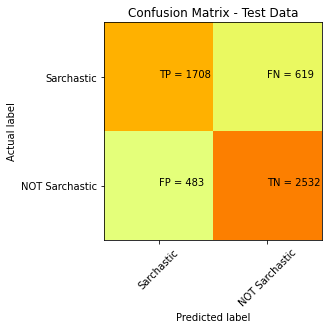

In [47]:
plt.clf()
plt.imshow(ConMatrix, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Sarchastic','NOT Sarchastic']
plt.title('Confusion Matrix - Test Data')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TP','FN'], ['FP', 'TN']]
 
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(ConMatrix[i][j]))
plt.show()